# Tabular Q-Learning


In [2]:
#import libraries and dependancies
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
# Import the state and action pairs generated by following a random policy
data = np.genfromtxt('data_state_action_RL.csv',delimiter=',',dtype=None)

In [5]:
# Store the State and Action Data separately for clustering
state_space_data = data[:,:376]
action_space_data= data[:,376:]

In [6]:
#create environment
env = gym.make('Humanoid-v2')

In [8]:
#Our model parameters
total_episodes = 3000
K = 1
#Learning rate
alpha = 0.01
#Discount rate
gamma = 0.999
#Exploration proportion
epsilon = 0.999
# Number of clusters of state
num_clusters_s = 1000
#Number of clusters of action
num_clusters_a = 100

max_iter = 3000
n_runs = 10
n_actions = env.action_space.shape[0]

In [9]:
#process the state/action space, run clustering algorithm on it and 
#return the k_means model fitted on the input states
def process_state(s, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='random',max_iter=max_iter, tol=1e-04, random_state=0)
    k_means_state= kmeans.fit(s)
    return k_means_state


In [10]:
#create a dictionary containing correspondence between cluster centers 
#for state/action and index given k_means model and the input states
def create_state_dict(k_means_state, num_clusters):
    dict = {}
    #print('index -- state dict', num_clusters)
    for i in range(num_clusters):
        dict[i]= k_means_state.cluster_centers_[i]
    return dict
    

In [11]:
#processing the initial data obtained from random sampling and clustering it
states_k_means = process_state(state_space_data,num_clusters_s)
action_k_means = process_state(action_space_data,num_clusters_a)

In [12]:
# creating dictionaries with 1:1 correpondence between idx and cluster center
clustered_state_dict = create_state_dict(states_k_means,  num_clusters_s)
clustered_action_dict = create_state_dict(action_k_means,  num_clusters_a)

index -- state dict 1000
index -- state dict 100


In [13]:
# Q-learning (off-policy TD learning) with epsilon greedy
def policy_learnt(Q, state,state_idx, env, epsilon):
  if np.random.random() < epsilon:
    action_1 = env.action_space.sample()
    action_1 = action_1.astype(float)
    action_idx = action_k_means.predict(action_1.reshape(1,-1))
    action_idx = tuple(action_idx)[0]
    return action_idx # return a random action
  else:
    return np.argmax(Q[state_idx, :]) # return the action which 
                                # gives the maximum reward for an action

In [15]:
# Q-learning (off-policy TD learning) with epsilon greedy
def on_policy(Q, state,state_idx, env, epsilon):
    return np.argmax(Q[state_idx, :]) # return the action which 
                                # gives the maximum reward for an action

In [17]:
def train(env, policy, total_episodes = 5, run_test = False, test_freq = 10):
  
  # Set the agent at starting position
  state = env.reset()
#   print('s',state)
  # process the current state to a cluster state
  state_idx = states_k_means.predict(state.reshape(1,-1)) #index of the predicted cluster
#   print('stae', state_idx)
  state = clustered_state_dict[tuple(state_idx)[0]] #the center of the predicted cluster --processed state

  # Initialize Q values as 0-- the size of Q depends on the number of cluster
  Q = np.zeros((num_clusters_s, num_clusters_a))
  cumulative_reward = 0
  n_episodes = 0
    
  train_episode_rewards = []
  train_episode_average_rewards = []
    
  test_rewards = []
  env.render()
  
  num_iterations = 0
  episode_iter = 0
  # Here an episode only ends once we reach the goal location. 
  while n_episodes < total_episodes:
 
    #find action given by policy for this state
    action_idx = policy_learnt(Q,state,state_idx, env, epsilon)
    action = clustered_action_dict[action_idx]   
    
    prev_state = state
    prev_state_idx = state_idx
    
    # Step the environment forward
    state, reward, done, info = env.step(action)
    num_iterations +=1
    episode_iter +=1

    
    if not done:
        state_idx = states_k_means.predict(state.reshape(1,-1)) #index of the next predicted cluster
        state = clustered_state_dict[tuple(state_idx)[0]] #the center of the predicted cluster -- processed state
        
    # Now we have our current state, action, next state and reward
    # So we can take our updates
        future_reward = reward + gamma*np.max(Q[state_idx, :])
        expected_future_reward = Q[prev_state_idx, action_idx]
        Q[state_idx, action_idx] += alpha*(future_reward-expected_future_reward)
        cumulative_reward += reward
        
      
    # Reset the agent if we're done and track rewards
    if done:
        future_reward = reward
        expected_future_reward = Q[prev_state_idx, action_idx]
        Q[state_idx, action_idx] += alpha*(future_reward-expected_future_reward)
        cumulative_reward += reward
        average_reward = cumulative_reward/episode_iter

        train_episode_rewards.append(cumulative_reward)
        train_episode_average_rewards.append(average_reward)
        
        s = env.reset()
        n_episodes += 1
        episode_iter  = 0
        cumulative_reward = 0
        
  return train_episode_rewards, train_episode_average_rewards, Q

In [19]:
qlearning_average_rewards = np.zeros((total_episodes))
qlearning_rewards = np.zeros((total_episodes))
qpolicy = lambda q,s: policy_learnt(q, s, s_idx, env, epsilon)


  # Train with Q-learning
rewards, average_rewards, Q_q = train(env, qpolicy, total_episodes)
qlearning_rewards[:] = rewards
qlearning_average_rewards[:] = average_rewards
#print('avg',average_rewards)
  

Creating window glfw


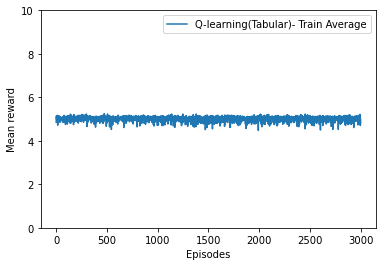

In [21]:
plt.plot(qlearning_average_rewards)
#plt.plot(qlearning_average_rewards)
plt.legend(['Q-learning(Tabular)- Train Average'])
plt.xlabel('Episodes')
plt.ylabel('Mean reward');
plt.ylim([0,10]);

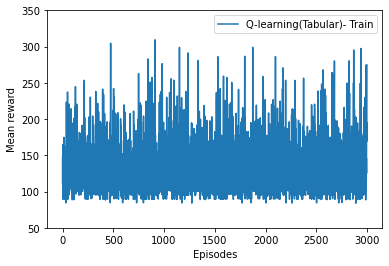

In [22]:
plt.plot(qlearning_rewards)
#plt.plot(qlearning_rewards)
plt.legend(['Q-learning(Tabular)- Train'])
plt.xlabel('Episodes')
plt.ylabel('Mean reward');
plt.ylim([50,350]);

In [23]:
np.save('Tabular_Q_Learning_train_avg',qlearning_average_rewards)

In [18]:
env.close()